## Loading

In [21]:
import cv2
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import os
import zipfile

## Main

In [22]:
# Helper function to extract frames from video
# def extract_frames(video_path, frame_rate=1):
#     clip = VideoFileClip(video_path)
#     fps = clip.fps
#     frame_list = []
#     timestamps = []

#     for i, frame in enumerate(clip.iter_frames()):
#         if i % int(fps / frame_rate) == 0:
#             frame_list.append(frame)
#             timestamps.append(i / fps)

#     return frame_list, timestamps

# Helper function to extract 25 evenly spaced frames from the video
def extract_frames(video_path, num_frames=25):
    clip = VideoFileClip(video_path)
    total_frames = int(clip.fps * clip.duration)  # Total number of frames in the video
    frame_indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)  # Generate 25 evenly spaced indices
    
    frame_list = []
    timestamps = []

    for idx, frame in enumerate(clip.iter_frames()):
        if idx in frame_indices:
            frame_list.append(frame)
            timestamps.append(idx / clip.fps)

    return frame_list, timestamps


In [23]:
def process_frames_to_dataframe(frames, timestamps):
    def build_autoencoder(input_shape=(224, 224, 3)):
        input_layer = Input(shape=input_shape)

        # Encoder
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
        x = MaxPooling2D((2, 2))(x) 
        x = Dropout(0.25)(x) 
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x) 
        x = Dropout(0.25)(x) 
        x = Flatten()(x)
        latent_space = Dense(16, activation='relu', name='latent_features')(x)

        # Decoder
        x = Dense(56 * 56 * 16, activation='relu')(latent_space)
        x = Reshape((56, 56, 16))(x)
        x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x) 
        x = Dropout(0.25)(x) 
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x) 
        decoded_output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

        # Models
        autoencoder = Model(inputs=input_layer, outputs=decoded_output)
        encoder = Model(inputs=input_layer, outputs=latent_space)

        autoencoder.compile(optimizer='adam', loss='mse')
        return autoencoder, encoder


    def manual_kmeans(data, n_clusters, max_iter=10, tol=1e-4):
        # Randomly initialize centroids using a small sample of the data
        np.random.seed(0)
        centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]

        for iteration in range(max_iter):
            # Compute distances and assign clusters (vectorized)
            distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
            labels = np.argmin(distances, axis=1)

            # Compute new centroids
            new_centroids = np.array([
                data[labels == cluster].mean(axis=0) if (labels == cluster).any() else centroids[cluster]
                for cluster in range(n_clusters)
            ])

            # Check for convergence
            if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
                break

            centroids = new_centroids

        return centroids, labels

    print("Resizing frames...")
    resized_frames = np.array([cv2.resize(frame, (224, 224)) for frame in frames])
    resized_frames = resized_frames / 255.0

    autoencoder, encoder = build_autoencoder()
    autoencoder.summary()

    frames = np.array(resized_frames)

    print("Training the autoencoder...")
    autoencoder.fit(frames, frames, epochs=100, batch_size=5, verbose=1)

    print("Extracting latent features...")
    latent_features = encoder.predict(frames)

    print("Calculating brightness...")
    brightness = np.array([
        frame.sum() / (frame.shape[0] * frame.shape[1] * frame.shape[2]) for frame in frames
    ])

    print("Clustering for dominant colors...")
    reshaped_frames = frames.reshape(-1, 3)  # Flatten frames to pixel-level colors

    # Sample a subset of pixels for clustering
    sample_indices = np.random.choice(reshaped_frames.shape[0], size=10000, replace=False)
    sampled_pixels = reshaped_frames[sample_indices]

    # Perform manual K-Means clustering on the sampled pixels
    dominant_colors, _ = manual_kmeans(sampled_pixels, n_clusters=3)

    # Map dominant colors back to frames
    color_features = []
    for frame_pixels in tqdm(frames, desc="Mapping dominant colors to frames"):
        frame_pixels = frame_pixels.reshape(-1, 3)
        distances = np.linalg.norm(frame_pixels[:, None, :] - dominant_colors[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Calculate average colors for the frame
        color_sums = np.zeros((3, 3))
        count = np.zeros(3)
        for label, pixel in zip(labels, frame_pixels):
            color_sums[label] += pixel
            count[label] += 1

        avg_colors = np.divide(color_sums, count[:, None], where=(count[:, None] != 0))
        color_features.append(avg_colors.mean(axis=0))  # Combine per-cluster colors

    print("Reducing dimensions of latent features...")
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(latent_features)

    print("Combining features into a DataFrame...")
    data = {
        "timestamp": timestamps,
        "brightness": brightness,
        "color1": [c[0] for c in color_features],
        "color2": [c[1] for c in color_features],
        "color3": [c[2] for c in color_features],
        "feature1": reduced_features[:, 0],
        "feature2": reduced_features[:, 1],
    }
    feature_df = pd.DataFrame(data)

    return feature_df


In [24]:
# # Main function to process video and return a DataFrame
# def analyze_video(video_path):
#     print("Extracting frames from video...")
#     frames, timestamps = extract_frames(video_path, num_frames=25)

#     print("Analyzing frames...")
#     df = process_frames_to_dataframe(frames, timestamps)

#     return df

# Function to process a zip file containing video files
def analyze_videos(zip_path, output_dir="extracted_videos"):
    
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    
    video_files = [os.path.join(output_dir, file) for file in os.listdir(output_dir) if file.endswith(".mp4")]
    
    if not video_files:
        raise ValueError("No .mp4 files found in the zip file.")
    
    all_results = []
    for video_path in video_files:
        print(f"Analyzing video: {video_path}")
        try:
            df_results = analyze_video(video_path)
            df_results["video_name"] = os.path.basename(video_path)
            all_results.append(df_results)
        except Exception as e:
            print(f"Error processing {video_path}: {e}")
    
    print("Combining results...")
    combined_df = pd.concat(all_results, ignore_index=True)
    return combined_df


## Run

In [25]:
# Upload and analyze your .mp4 video file
zip_file_path = "videos_downloaded.zip"
df_results = analyze_videos(zip_file_path)

# Display the DataFrame
print(df_results)

Extracting zip file...
Analyzing video: extracted_videos\1OHZTFseggA.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0970
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0760
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0818
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0790
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0733
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0661
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0720
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0670
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0693
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0598
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0592
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0548
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0479
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0534
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.82it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\1rJa-0YOkwk.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0849
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0737
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0835
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0785
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0604
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0788
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0535
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0552
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0667
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0503
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0552
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0477
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0571
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0427
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.72it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\2VK_awDJ_ss.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.1244
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1328
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1067
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.1042
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0912
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0792
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0525
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0487
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0499
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0491
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0502
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0431
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0387
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0442
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.75it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\4RcThoRG46c.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0979
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0919
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1055
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0962
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0895
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1001
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0987
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0944
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0839
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0763
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0754
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0646
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0735
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0743
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.98it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\4wHkhxit_sU.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0794
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0753
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0755
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0697
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0668
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0686
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0789
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0730
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0636
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0661
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0651
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0653
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0595
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0613
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.72it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\8AuAv0eQlBI.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0737
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0639
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0643
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0540
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0545
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0516
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0725
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0565
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0529
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0436
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0646
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0648
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0537
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0438
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.77it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\9a42bdlFRxM.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0938
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0836
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0882
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0766
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0761
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0777
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0893
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0610
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0733
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0660
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0758
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0705
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0699
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0841
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 15.85it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\awY7eX8rguw.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.1083
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1029
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0885
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0892
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0772
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0719
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0715
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0496
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0497
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0443
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0349
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0375
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0350
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0333
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.83it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\b4x8boB2KdI.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_18 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_19 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0934
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0712
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0722
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0682
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0645
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0671
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0579
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0529
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0546
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0468
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0429
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0396
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0376
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0305
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.10it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\CHv-oKQcjF8.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0799
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0794
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0674
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0714
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0852
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0786
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0823
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0789
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0642
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0681
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0716
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0639
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0559
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0546
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.57it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\ciR9HfGTlf0.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_34             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_23 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_35             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1080
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0898
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0621
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0576
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0600
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0520
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0476
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0483
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0481
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0450
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0399
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0350
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0326
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0274
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.60it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\cRPBp2tRxFY.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_36             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_37             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0795
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0759
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0735
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0631
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0624
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0572
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0532
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0549
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0508
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0458
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0476
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0456
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0410
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0404
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.70it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\CUOzCh_Pcrg.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_13 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_39             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_26 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_27 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0581
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0466
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0432
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0433
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0450
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0412
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0387
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0385
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0376
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0436
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0409
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0392
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0406
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0373
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 17.24it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\CwaZ47RUjoU.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_28 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_43             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_29 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_44             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1132
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1164
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1060
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0971
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1042
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0919
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0798
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0629
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0512
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0446
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0423
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0360
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0343
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0315
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\e_utOqzf5j0.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_15 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_45             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_30 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_46             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_31 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_47             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0997
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0930
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0983
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0996
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0871
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0850
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0748
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0774
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0709
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0702
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0695
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0711
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0750
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0679
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 12.59it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\FLrbO71yQUA.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_16 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_48             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_32 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_49             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_33 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_50             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0538
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0528
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0478
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0482
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0430
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0410
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0440
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0432
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0399
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0395
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0365
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0344
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0351
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0312
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.54it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\FZzZatxb9KQ.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_17 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_51             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_34 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_52             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_35 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_53             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0585
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0534
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0476
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0462
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0479
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0467
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0473
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0453
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0453
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0461
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0441
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0446
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0462
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0457
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 17.11it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\G7o7Qz08RrI.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_18 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_54             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_36 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_55             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_37 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_56             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0862
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0757
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0798
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0756
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0806
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0639
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0648
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0607
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0598
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0539
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0547
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0646
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0491
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0590
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.73it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\H17T4dH7-W0.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_19 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_57             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_38 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_58             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_39 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_59             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0699
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0862
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0754
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0765
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0691
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0607
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0573
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0720
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0709
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0648
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0627
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0657
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0570
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0647
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 15.86it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\h3BKjZMGoIw.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_20 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_60             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_40 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_61             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_41 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_62             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0856
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0733
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0714
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0769
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0607
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0700
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0655
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0616
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0641
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0510
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0632
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0531
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0521
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0467
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 17.04it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\hPf2qu5U6F8.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_21 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_63             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_42 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_64             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_43 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_65             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.1190
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.1157
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0872
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0833
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0798
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0864
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0811
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0830
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0720
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0719
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0852
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0722
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0748
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0693
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.92it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\IFthVfjoVOc.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_22 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_66             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_44 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_67             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_45 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_68             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0805
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0804
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0772
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0725
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0744
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0711
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0698
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0694
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0653
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0637
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0588
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0533
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0521
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0502
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:02<00:00, 11.93it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\iXa5Bk0pu0w.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_69             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_46 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_70             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_47 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_71             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0661
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0644
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0724
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0540
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0616
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0543
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0528
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0521
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0735
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0609
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0630
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0515
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0449
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0380
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.11it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\MRtg6A1f2Ko.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_24 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_72             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_48 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_73             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_49 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_74             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0935
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0767
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0786
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0627
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0611
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0571
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0585
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0593
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0497
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0526
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0405
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0576
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0436
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0465
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 15.99it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\neIYdLysqlk.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_25 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_75             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_50 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_76             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_51 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_77             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0980
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0945
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0908
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0805
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0789
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0770
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0886
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0779
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0761
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0628
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0582
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0452
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0424
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0475
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.25it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\nK9zxuXa3OA.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_26 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_78             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_52 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_79             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_53 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_80             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0843
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0760
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0653
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0608
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0629
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0485
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0628
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0556
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0490
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0461
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0465
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0474
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0440
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0420
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.25it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\PCEmUPqSK4k.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_27 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_81             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_54 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_82             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_55 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_83             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0940
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0703
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0837
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0606
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0721
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0668
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0672
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0697
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0662
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0686
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0581
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0622
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0498
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0593
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.01it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\PIun_aBsRMA.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_28 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_84             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_56 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_85             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_57 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_86             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0704
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0674
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0582
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0554
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0520
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0505
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0506
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0475
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0486
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0507
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0471
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0505
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0490
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0475
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\pk9RKCRdWyc.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_29 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_87             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_58 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_88             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_59 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_89             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0843
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0958
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0797
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0831
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0852
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0805
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0813
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0673
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0584
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0506
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0425
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0387
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0396
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0343
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.56it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\qExcc92zHfo.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_30 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_90             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_60 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_91             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_61 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_92             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0761
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0706
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0547
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0470
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0483
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0529
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0404
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0527
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0438
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0440
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0476
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0417
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0380
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0405
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 17.14it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\QptbdEci-m8.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_31 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_93             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_62 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_94             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_63 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_95             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1024
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0880
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0968
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0982
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0862
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0771
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0876
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0863
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0748
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0691
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0636
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0644
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0578
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0613
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.86it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\qYztDs8vPBg.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_32 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_96             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_64 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_97             │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_65 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_98             │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0741
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0687
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0616
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0607
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0606
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0574
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0578
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0559
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0575
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0542
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0551
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0545
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0529
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0510
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.46it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\ThmKbekcisg.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_33 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_99             │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_66 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_100            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_67 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_101            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1088
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0799
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0593
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0510
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0488
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0541
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0518
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0567
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0467
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0468
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0411
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0366
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0350
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0364
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 15.28it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\TJqTr8_w588.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_34 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_34 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_102            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_68 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_103            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_69 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_104            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0942
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0825
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0769
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0845
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0832
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0657
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0644
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0601
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0577
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0609
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0538
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0580
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0537
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0573
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.58it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\tYJWcs-qnAc.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_35 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_35 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_105            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_70 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_106            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_71 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_107            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1023
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1019
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1001
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0953
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0840
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0883
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0875
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0782
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0723
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0829
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0703
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0800
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0670
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0690
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.78it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\ulXeKHtePDI.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_36 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_108            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_72 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_109            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_73 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_110            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0581
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0510
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0524
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0553
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0429
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0495
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0461
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0446
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0448
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0446
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0411
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0399
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0392
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0361
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.66it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\VS66VOUmoKQ.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_37 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_111            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_74 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_112            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_75 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_113            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0802
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0743
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0690
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0675
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0694
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0683
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0680
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0629
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0624
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0563
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0566
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0511
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0489
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0486
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.62it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\vSIbvJB4WdI.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_38 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_114            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_76 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_115            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_77 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_116            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0745
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0662
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0685
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0761
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0616
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0731
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0629
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0589
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0527
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0572
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0507
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0628
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0549
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0460
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.06it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\w9EbwjnpKaA.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_39 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_117            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_78 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_118            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_79 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_119            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1109
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1082
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0958
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0925
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0904
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0907
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0983
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0884
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0838
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0705
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0573
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0555
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0511
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0473
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 15.74it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\yro-CI984mE.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_40 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_120            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_80 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_121            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_81 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_122            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.1032
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0920
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0892
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0959
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0820
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0792
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0637
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0606
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0567
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0577
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0506
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0592
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0482
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0528
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.55it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\Yv_S7KrOlfk.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_41 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_123            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_82 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_124            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_83 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_125            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0880
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0838
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0797
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0719
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0662
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0612
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0684
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0551
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0612
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0537
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0511
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0619
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0532
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0547
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\YX8ks42Azn8.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_42 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_126            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_84 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_127            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_85 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_128            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1237
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0907
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0705
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0565
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0455
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0407
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0490
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0425
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0379
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0358
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0411
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0383
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0410
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0340
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.11it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\z19HM7ANZlo.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_43 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_129            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_86 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_130            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_87 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_131            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.1039
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0903
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0854
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0799
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0839
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0757
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0732
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0741
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0795
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0716
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0719
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0645
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0588
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0554
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.25it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\ZoTCq6zunl0.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_44 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_132            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_88 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_133            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_89 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_134            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0769
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0523
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0512
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0532
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0465
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0476
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0478
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0413
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0459
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0441
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0408
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0410
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0393
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0393
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.21it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Analyzing video: extracted_videos\_ybbXIksjUk.mp4
Extracting frames from video...
Analyzing frames...
Resizing frames...


Model: "functional_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_90 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_135 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_136 (Dropout)           │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_45 (Flatten)            │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_features (Dense)         │ (None, 16)             │       802,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 50176)          │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_45 (Reshape)            │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_135            │ (None, 56, 56, 16)     │         2,320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_90 (UpSampling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_136            │ (None, 112, 112, 32)   │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_91 (UpSampling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_137            │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669,171 (6.37 MB)

 Trainable params: 1,669,171 (6.37 MB)

 Non-trainable params: 0 (0.00 B)

Training the autoencoder...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0870
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0829
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0548
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0663
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0522
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0551
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0609
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0541
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0364
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0399
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0412
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0355
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0428
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0297
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss

Mapping dominant colors to frames: 100%|██████████| 25/25 [00:01<00:00, 16.61it/s]


Reducing dimensions of latent features...
Combining features into a DataFrame...
Combining results...
       timestamp  brightness        color1       color2       color3  \
0       0.000000    0.048873      0.017620     0.017576     0.017422   
1      27.133333    0.620852      0.513753     0.493153     0.498898   
2      54.300000    0.794294      0.501946     0.540978     0.586987   
3      81.433333    0.640973      0.547762     0.526128     0.527825   
4     108.600000    0.702965      0.588442     0.491026     0.491968   
...          ...         ...           ...          ...          ...   
1120  520.286433    0.564991      0.635179     0.532331     0.478684   
1121  546.312433    0.662700      0.648640     0.520150     0.458443   
1122  572.305067    0.628168      0.651022     0.559615     0.524859   
1123  598.331067    0.626140      0.642093     0.498085     0.454436   
1124  624.357067    0.000017  11943.522882  9503.150333  8634.328110   

       feature1   feature2       

            color1       color2       color3
0         0.017620     0.017576     0.017422
1         0.513753     0.493153     0.498898
2         0.501946     0.540978     0.586987
3         0.547762     0.526128     0.527825
4         0.588442     0.491026     0.491968
...            ...          ...          ...
1120      0.635179     0.532331     0.478684
1121      0.648640     0.520150     0.458443
1122      0.651022     0.559615     0.524859
1123      0.642093     0.498085     0.454436
1124  11943.522882  9503.150333  8634.328110

[1125 rows x 3 columns]


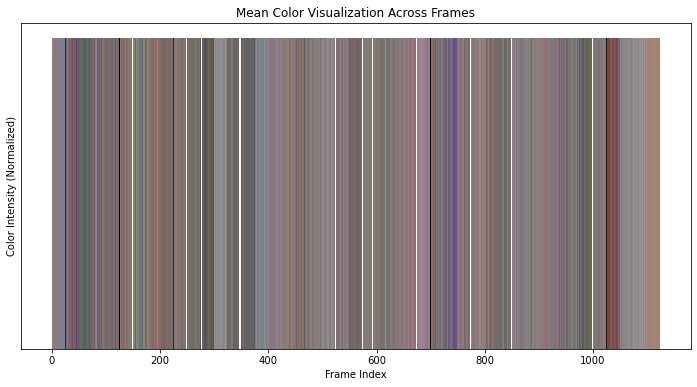

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_colors(feature_df):
    # Extract mean colors
    mean_colors = feature_df[["color1", "color2", "color3"]]

    # Create a figure
    plt.figure(figsize=(12, 6))

    print(mean_colors)
    # Loop through each frame's color and plot
    for i, color in enumerate(mean_colors.values):
        # Ensure the color is a tuple of 3 values
        color = np.clip(color, 0, 1)
        color = tuple(color)  # Convert to tuple for safety
        plt.bar(i, 1, color=color, width=1.0, edgecolor='none')  # Use color as RGB

    # Add plot details
    plt.title("Mean Color Visualization Across Frames")
    plt.xlabel("Frame Index")
    plt.ylabel("Color Intensity (Normalized)")
    plt.yticks([])  # Remove y-axis ticks for better clarity
    plt.show()

# Example usage
# Assuming `feature_df` is your dataframe with the given structure
plot_mean_colors(df_results)


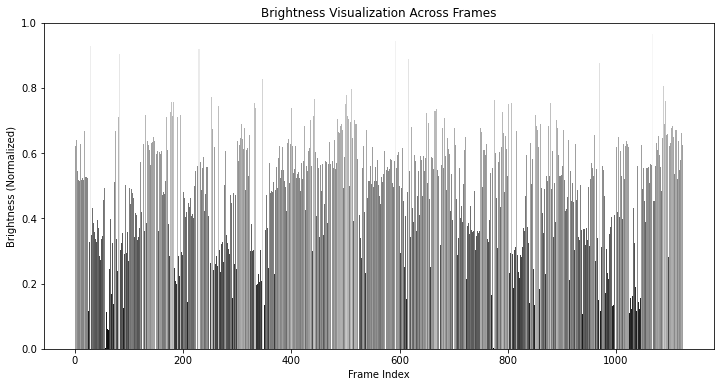

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_brightness(feature_df):
    # Extract brightness values
    brightness = feature_df["brightness"].values

    # Create a figure
    plt.figure(figsize=(12, 6))

    # Normalize brightness for color mapping (grayscale between 0 and 1)
    brightness_normalized = np.clip(brightness, 0, 1)

    # Loop through each frame's brightness and plot
    for i, value in enumerate(brightness_normalized):
        # Use grayscale for color (same intensity for R, G, B)
        gray_color = (value, value, value)
        plt.bar(i, value, color=gray_color, width=1.0, edgecolor='none')

    # Add plot details
    plt.title("Brightness Visualization Across Frames")
    plt.xlabel("Frame Index")
    plt.ylabel("Brightness (Normalized)")
    plt.ylim(0, 1)  # Brightness is normalized between 0 and 1
    plt.show()

# Example usage
# Assuming `feature_df` is your dataframe with the given structure
plot_brightness(df_results)

In [28]:
from sklearn.preprocessing import StandardScaler

# List of features to scale
features_to_scale = ['brightness', 'color1', 'color2', 'color3', 'feature1', 'feature2']

# Standardize the features
scaler = StandardScaler()
df_results[features_to_scale] = scaler.fit_transform(df_results[features_to_scale])

In [29]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(df_results[features_to_scale])

# Convert to DataFrame
interaction_df = pd.DataFrame(interaction_features, columns=poly.get_feature_names_out(features_to_scale))

# Add to original DataFrame
df_results = pd.concat([df_results, interaction_df], axis=1)

In [30]:
print(df_results.corr())

                     timestamp  brightness    color1    color2    color3  \
timestamp             1.000000   -0.134864  0.114628  0.117033  0.115517   
brightness           -0.134864    1.000000 -0.260484 -0.267530 -0.267208   
color1                0.114628   -0.260484  1.000000  0.993792  0.987986   
color2                0.117033   -0.267530  0.993792  1.000000  0.998024   
color3                0.115517   -0.267208  0.987986  0.998024  1.000000   
feature1              0.045168    0.010975  0.104513  0.100875  0.098490   
feature2             -0.029858    0.002038  0.023737  0.028146  0.026680   
brightness           -0.134864    1.000000 -0.260484 -0.267530 -0.267208   
color1                0.114628   -0.260484  1.000000  0.993792  0.987986   
color2                0.117033   -0.267530  0.993792  1.000000  0.998024   
color3                0.115517   -0.267208  0.987986  0.998024  1.000000   
feature1              0.045168    0.010975  0.104513  0.100875  0.098490   
feature2    

In [31]:
df_results.to_csv('ImageCNNResults.csv')